In [2]:
import pandas as pd
from time import time
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from scipy.spatial.distance import cosine 
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils
from collections import Counter
import numpy as np
from ast import literal_eval
from sklearn.manifold import TSNE
tsne=TSNE(metric='cosine')

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ionab\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Genre Classification using the doc2vec Model
One of the main goals of this project is to identify the genre of a song using the lyrics. Most of what defines the genre of a song is the music (rhythm, beat, instruments etc). But we would like to see if we can estimate the genre of a song based on the lyrics alone. We propose two different methods: embedding the lyric text, and regressing over features of the lyrics such as word-count and other derived variables.

## Load the dataset and model

In [3]:
model = Doc2Vec.load("../Data/doc2vec100.model")

In [4]:
song_df=pd.read_csv("../Data/song_vecs100.csv",sep=',',encoding='utf-8')
song_df.set_index('index',inplace=True)
song_df.sort_index(inplace=True)
song_df['tokens']=[literal_eval(t) for t in song_df.tokens]
song_df['vec100']=[[float(y) for y in x[1:-1].split()] for x in song_df.vec100]
print(len(song_df))
song_df.head()

56148


,language,artist,link,song,lyrics,release_date,album,genre,song_length,label,tokens,vec100
index,,,,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153,"""She's My Kind Of Girl"" by ABBA","[look, face, wonderful, face, means, special, ...","[-0.1552842, 0.32124212, -0.10973388, 0.398913..."
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260,"""Andante, Andante"" by ABBA","[easy, touch, gently, like, summer, evening, b...","[-0.49583471, 0.06956885, 0.10521561, 0.064079..."
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312,"""As Good As New"" by ABBA","[know, lousy, rotten, boy, tough, packing, stu...","[0.27522475, 0.13831177, 0.1392298, 0.53600252..."
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200,"""Bang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.5095306, -0.26407892, 0.92521173, 0.100037..."
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198,"""Bang-A-Boomerang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.68000865, -0.22533123, 0.67675865, 0.08415..."


Sample for visualisation purposes (analysis is done on full dataset):

In [4]:
song_sample=song_df.query("genre==genre").sample(5000).loc[:,['label','vec100']]
song_sample.set_index('label', inplace=True)

## Topic Tagging
In order to estimate genres, we will create *genre vectors*. These vectors will be calculated using words that occur frequently in a particular genre. Thus, lyrics that are close to a given genre vector are estimated to be of that genre.

### Topic vectors from the data
We take the most common words for each genre in the dataset and create the following genre vectors.

In [5]:
data_samples=[]

genres=list(set(song_df.genre.dropna()))
for genre in genres:
    temp=song_df.query("genre == '{}'".format(genre))
    all_lyrics='\n'.join(temp.lyrics.dropna().tolist())
    data_samples.append(all_lyrics)

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)
tfidf = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf['Genre']=genres
tfidf.set_index('Genre', inplace=True)
tfidf

to_write=[]
for i,row in tfidf.iterrows():
    top_words=sorted(row.iteritems(), key= lambda x: x[1], reverse=True)
    to_write.append(i+'\t'+' '.join([w[0] for w in top_words[:100]]))

with open('../Data/genres.txt', 'w') as f:
    f.write('\n'.join(to_write))

In [22]:
with open("../Data/genres.txt",'r') as f:
    topics=f.read()
    topics=pd.DataFrame([t.split('\t') for t in topics.split('\n')], columns=['Genre','words'])
    topics.set_index('Genre', inplace=True)

topics['vector']=[model.infer_vector(w) for w in topics.words]
topics

,words,vector
Genre,,
Jazz,ahoy da giddyup lug bon thing chug said si shi...,"[-0.00333541, -0.00346724, 0.00173441, -0.0041..."
R&B,wanna ooh said gotta thing tonight ya la stop ...,"[-0.00382867, -0.00143117, -0.00431324, -0.004..."
Country,said thing town wanna tonight thought lord big...,"[-0.00484977, -0.0028578, -0.00106931, -0.0002..."
Classical,matilda mackie waltzing tonight auld face syne...,"[0.00315712, -0.00210697, 0.00073729, 0.001853..."
Holiday,christmas pum chee santa merry jingle rum bell...,"[0.00220542, -0.00180118, 0.00288501, 0.002431..."
Metal,dead hell death blood god soul fear face said ...,"[0.00408379, -0.00103651, 0.00287013, 0.002232..."
Folk,la said road cold morning chickenman town big ...,"[-0.00105381, -0.00254281, -0.0001026, 0.00306..."
Punk,la wart said beat wrong thing face dead hate f...,"[0.00035128, -0.00406136, 0.000165305, -0.0040..."
Non-music,bama bad marie culture yeady understand lama v...,"[-0.00444942, 0.00175225, 0.00278759, 3.50659e..."


In [6]:
%time vec2D=tsne.fit_transform(topics.vector.tolist()+song_sample.vec100.tolist())

topics['x']=[x[0] for x in vec2D[:len(topics)]]
topics['y']=[x[1] for x in vec2D[:len(topics)]]

song_sample['x']=[x[0] for x in vec2D[len(topics):]]
song_sample['y']=[x[1] for x in vec2D[len(topics):]]

song_sample.head()

Wall time: 2min 23s


,vec100,x,y
label,,,
"""Cold Love"" by Donna Summer","[-0.10374325, -0.02215567, -0.11335889, 0.1274...",-15.786949,2.758523
"""My Girls"" by Christina Aguilera","[-0.121990003, 0.395928144, 0.105123028, 0.836...",-6.543884,35.492371
"""Dixie"" by Bob Dylan","[0.0566568, -0.00160155, 0.17665856, 0.1728837...",6.018469,3.398131
"""Doa"" by Foo Fighters","[0.00561829, 0.04246531, -0.11432555, -0.09021...",-38.692802,-24.757627
"""Shame, Shame, Shame"" by Aerosmith","[-0.43974224, 0.00933752, 0.25741211, -0.04510...",4.429191,33.398396


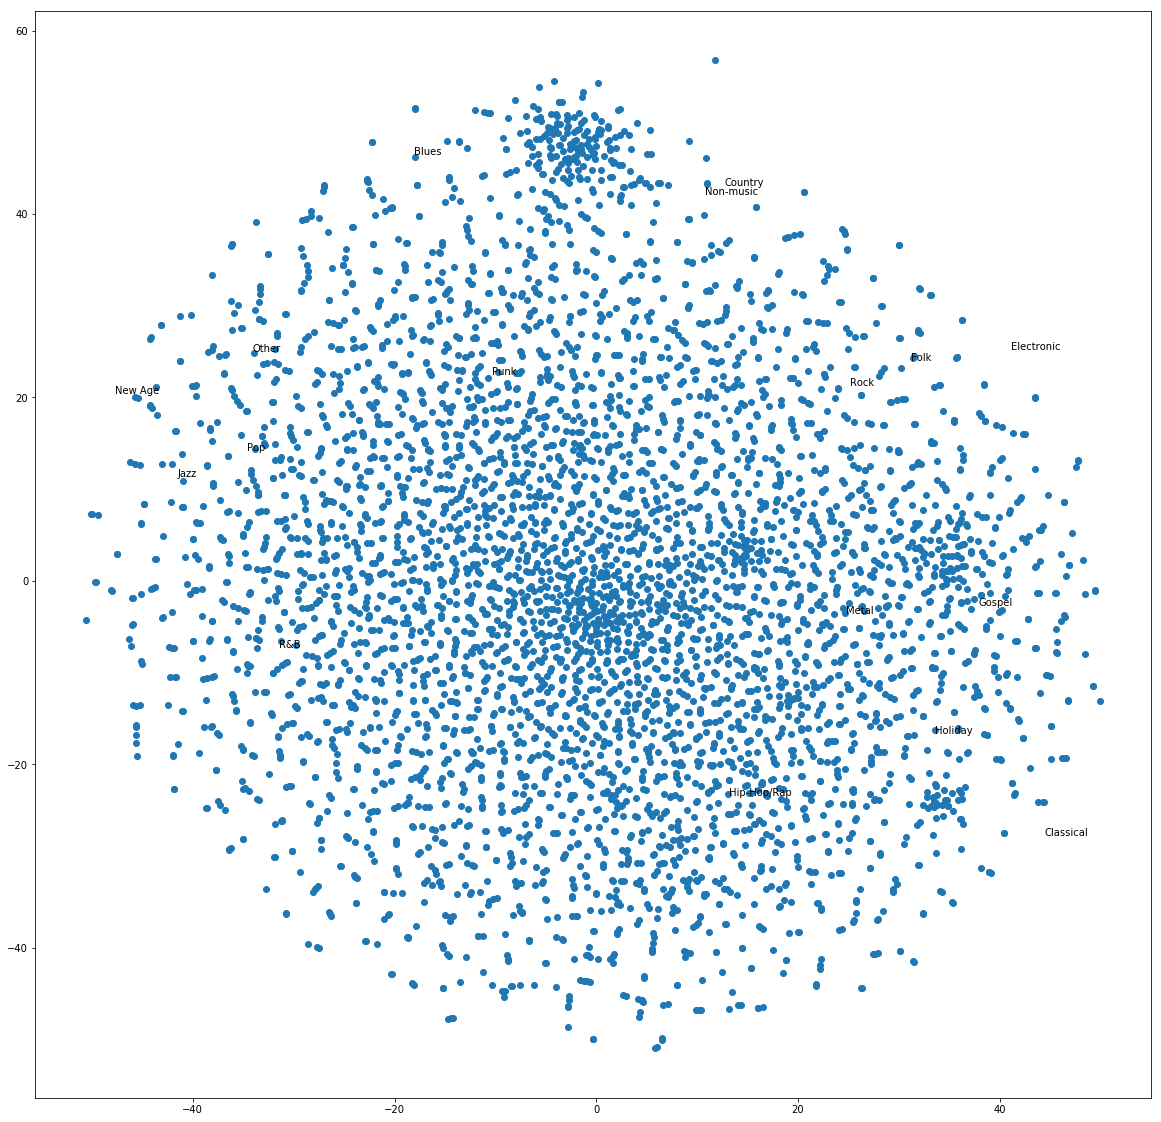

In [7]:
plt.figure(figsize=(20,20))
plt.plot(song_sample['x'],song_sample['y'], 'o')
[plt.text(row['x'],row['y'], i, size='xx-large') for i,row in topics.iterrows()]
plt.savefig('../Figures/topic_vectors1.pdf')

For each song we estimate the three most likely genres.

Note: For some reason, SciPy's cosine function returns $1-\frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\|\|\vec{b}\|}$ so to get the actual cosine similarity, we calculate 1 - cosine(a,b).

In [23]:
song_df['est_genres']=[[]]*len(song_df)

for i,row in song_df.iterrows():
    sim={}
    for g in topics.index:
        sim[g]=1-cosine(model.docvecs[str(i)],topics.loc[g]['vector'])
    song_df.at[i,'est_genres']=[y[0] for y in sorted(sim.items(), key=lambda x: x[1], reverse=True)[:3]]

song_df.head()

,language,artist,link,song,lyrics,release_date,album,genre,song_length,label,tokens,vec100,est_genres
index,,,,,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153,"""She's My Kind Of Girl"" by ABBA","[look, face, wonderful, face, means, special, ...","[-0.1552842, 0.32124212, -0.10973388, 0.398913...","[Hip-Hop/Rap, Non-music, Other]"
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260,"""Andante, Andante"" by ABBA","[easy, touch, gently, like, summer, evening, b...","[-0.49583471, 0.06956885, 0.10521561, 0.064079...","[Pop, Metal, Other]"
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312,"""As Good As New"" by ABBA","[know, lousy, rotten, boy, tough, packing, stu...","[0.27522475, 0.13831177, 0.1392298, 0.53600252...","[Pop, Classical, Punk]"
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200,"""Bang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.5095306, -0.26407892, 0.92521173, 0.100037...","[Pop, Other, Blues]"
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198,"""Bang-A-Boomerang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.68000865, -0.22533123, 0.67675865, 0.08415...","[Pop, Other, Hip-Hop/Rap]"


The following confusion matrix shows the number of times a song of a particular genre (vertical) was estimated to be of another (horizontal). Since genres are often difficult to determine and there are not clear cut definitions, we deem a prediction successful if the pretagged genre is one of the three estimated genres.

In [24]:
genres=set(topics.index).intersection(set(song_df.genre.dropna()))
conf_mat=pd.DataFrame(columns=genres, index=genres)
conf_mat.fillna(0,inplace=True)
total=0
success=0
for i,row in song_df.iterrows():
    if type(row['genre'])==str and row['genre'] in genres:
        total+=1
        if row['genre'] in row['est_genres']:
            success+=1
        
        for est in row['est_genres']:
            if est in genres:
                conf_mat.at[row['genre'],est]=conf_mat.loc[row['genre']][est]+1

print("Success rate: ", success/total)                
conf_mat 

Success rate:  0.23003654889799535


,Jazz,Electronic,New Age,Rock,Folk,Gospel,Holiday,Pop,Punk,R&B,Other,Metal,Classical,Country,Hip-Hop/Rap,Non-music,Blues
Jazz,47,49,66,33,6,27,34,164,75,34,159,24,143,115,81,73,49
Electronic,50,57,62,19,17,20,36,162,50,30,109,38,97,119,80,57,89
New Age,3,3,7,2,1,1,3,9,3,3,12,4,14,12,3,4,6
Rock,1447,1464,1619,818,512,626,1012,3621,1404,1049,3039,1235,2855,2774,2095,2407,2263
Folk,97,113,138,90,35,52,63,248,137,61,205,84,231,159,125,139,111
Gospel,24,55,107,34,30,23,31,147,43,28,224,43,139,157,122,47,111
Holiday,18,25,126,13,3,20,29,177,33,24,105,25,122,166,67,99,31
Pop,1787,2112,2629,1172,606,973,1430,5587,2210,1383,5001,1557,4071,4093,3424,2852,3111
Punk,93,53,66,35,29,22,33,142,88,57,95,72,96,111,62,127,130
R&B,165,200,268,128,47,134,165,601,180,177,528,167,323,454,475,326,225


We divide each row by the number of songs of that genre and create a heatmap.  This proportional confusion matrix will identify bias in the classification model. We can see that this model often wrongly tags songs as being of the Jazza amd R&B genre. Since we did not have much training data from these two genres, the resulting vectors were possibly too general.

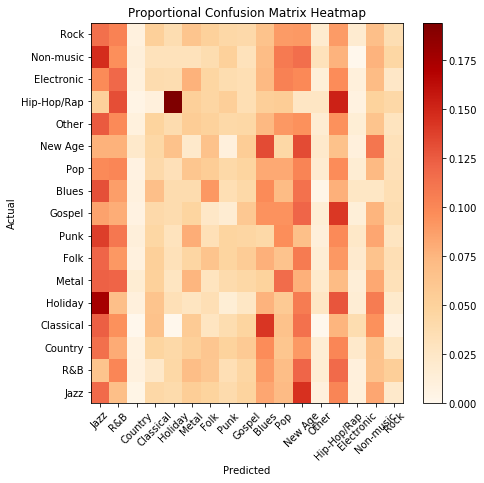

In [10]:
conf_mat_prop=conf_mat.copy()
totals=conf_mat.sum(axis=1)
for col in conf_mat.columns:
    conf_mat_prop[col]=conf_mat_prop[col].div(totals)
plt.figure(figsize=(7,7))
plt.pcolor(conf_mat_prop, cmap='OrRd')
plt.yticks(np.arange(0.5, len(conf_mat_prop.index), 1), conf_mat_prop.index)
plt.xticks(np.arange(0.5, len(conf_mat_prop.columns), 1), conf_mat_prop.columns, rotation=45)
plt.title('Proportional Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.savefig('../Figures/conf_heatmap1.pdf')
plt.show()

### Topic vectors from paper
These genre vectors have been created using the top 100 words for each genre in Fell and Sporleder's paper *Lyrics-based Analysis and Classification of Music* (http://www.aclweb.org/anthology/C14-1059). In this paper, they analyse a dataset of over 400 000 lyrics (compared to our 55 000) so we hope to get a more accurate prediction. These genre vectors are then the average of the words in each word cloud. Some of the genres in our dataset do not appear in Fell and Sporleder's paper so the algorithm will not be able to estimate the missing genres.

In [8]:
with open("../Data/topics-anthology.txt",'r') as f:
    topics=f.read()
    topics=pd.DataFrame([t.split('\t') for t in topics.split('\n')], columns=['Genre','words'])
    topics['Genre']=[t.title() for t in topics.Genre]
    topics.set_index('Genre', inplace=True)

topics['vector']=[model.infer_vector(w) for w in topics.words]
topics

,words,vector
Genre,,
Blues,FOOL DOG MIGHT LONESOME THING OH MEAN NOBODY T...,"[-0.00267856, -0.00244946, 0.00307826, 0.00446..."
Hip-Hop/Rap,CASH YO ROCK SPIT WANNA GUN DAMN PUT REAL OFF ...,"[0.00292622, 0.00406718, -0.00356297, -0.00308..."
Metal,BATTLE RISE END WAR FLAME ANGER CHAOS SUFFER H...,"[0.000215623, -0.00194329, 0.00121616, -0.0022..."
Folk,BLUE REMEMBER PRAY RAIN YEAR WELL FIRE GROUND ...,"[-0.00238893, -0.00310756, 0.00403248, -0.0029..."
R&B,PHONE WHEN OHH 'LL GAME SEXY KNOW WHATEVER WHY...,"[-0.0042534, 0.00246345, 0.00124155, -0.002617..."
Country,SMILE 'LL ALONG HONEY TONK DREAM HONKY GUITAR ...,"[-0.00449675, 0.00174344, -0.00444235, 0.00425..."
Gospel,SAVE LIFE THRONE FATHER FAITH PRAY HOLY GOD PR...,"[0.00233665, -0.00403934, 0.0022356, 0.0039087..."
Reggae,YOUTH HAFFI LIVE BAD TEK DI SEY FRIEND MUST SE...,"[0.00401261, -0.0042834, 0.000740697, 0.000816..."
Pop,SOMEONE SOUND WASH TRACK SUN ALRIGHT BETWEEN D...,"[0.00400011, 0.00339279, -0.00414893, 0.000747..."


In [9]:
%time vec2D=tsne.fit_transform(topics.vector.tolist()+song_sample.vec100.tolist())

topics['x']=[x[0] for x in vec2D[:len(topics)]]
topics['y']=[x[1] for x in vec2D[:len(topics)]]

song_sample['x']=[x[0] for x in vec2D[len(topics):]]
song_sample['y']=[x[1] for x in vec2D[len(topics):]]

song_sample.head()

Wall time: 2min 26s


,vec100,x,y
label,,,
"""Cold Love"" by Donna Summer","[-0.10374325, -0.02215567, -0.11335889, 0.1274...",-1.659657,0.379325
"""My Girls"" by Christina Aguilera","[-0.121990003, 0.395928144, 0.105123028, 0.836...",-6.894313,38.835682
"""Dixie"" by Bob Dylan","[0.0566568, -0.00160155, 0.17665856, 0.1728837...",-16.710192,-21.777172
"""Doa"" by Foo Fighters","[0.00561829, 0.04246531, -0.11432555, -0.09021...",36.999062,34.857376
"""Shame, Shame, Shame"" by Aerosmith","[-0.43974224, 0.00933752, 0.25741211, -0.04510...",3.544500,-0.423744


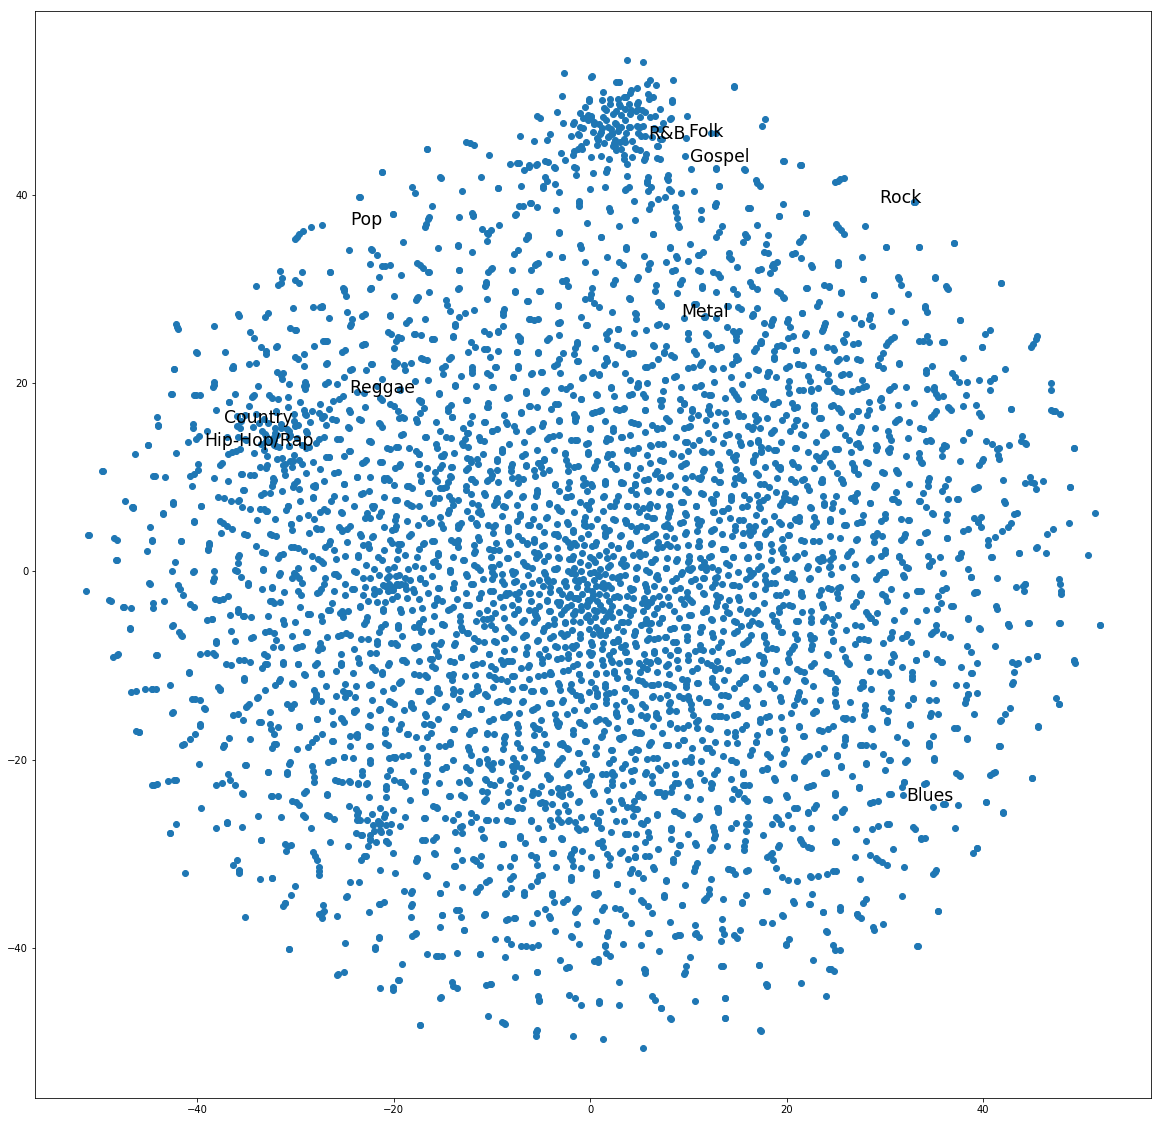

In [12]:
plt.figure(figsize=(20,20))
plt.plot(song_sample['x'],song_sample['y'], 'o')
[plt.text(row['x'],row['y'], i, size='xx-large') for i,row in topics.iterrows()]
plt.savefig('../Figures/topic_vectors2.pdf')

In [12]:
song_df['est_genres']=[[]]*len(song_df)

for i,row in song_df.iterrows():
    sim={}
    for g in topics.index:
        sim[g]=1-cosine(model.docvecs[str(i)],topics.loc[g]['vector'])
    song_df.at[i,'est_genres']=[y[0] for y in sorted(sim.items(), key=lambda x: x[1], reverse=True)[:3]]

song_df.head()

,language,artist,link,song,lyrics,release_date,album,genre,song_length,label,tokens,vec100,est_genres
index,,,,,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153,"""She's My Kind Of Girl"" by ABBA","[look, face, wonderful, face, means, special, ...","[-0.1552842, 0.32124212, -0.10973388, 0.398913...","[Gospel, Pop, Country]"
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260,"""Andante, Andante"" by ABBA","[easy, touch, gently, like, summer, evening, b...","[-0.49583471, 0.06956885, 0.10521561, 0.064079...","[Reggae, R&B, Gospel]"
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312,"""As Good As New"" by ABBA","[know, lousy, rotten, boy, tough, packing, stu...","[0.27522475, 0.13831177, 0.1392298, 0.53600252...","[Gospel, Rock, Blues]"
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200,"""Bang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.5095306, -0.26407892, 0.92521173, 0.100037...","[R&B, Reggae, Pop]"
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198,"""Bang-A-Boomerang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.68000865, -0.22533123, 0.67675865, 0.08415...","[R&B, Pop, Country]"


We will validate on the observations for which the genre is one of the possible genre vectors.

In [13]:
genres=set(topics.index).intersection(set(song_df.genre.dropna()))
conf_mat=pd.DataFrame(columns=genres, index=genres)
conf_mat.fillna(0,inplace=True)
total=0
success=0
for i,row in song_df.iterrows():
    if type(row['genre'])==str and row['genre'] in genres:
        total+=1
        if row['genre'] in row['est_genres']:
            success+=1
        
        for est in row['est_genres']:
            if est in genres:
                conf_mat.at[row['genre'],est]=conf_mat.loc[row['genre']][est]+1

print("Success rate: ", success/total)                
conf_mat 

Success rate:  0.3058779830996379


,R&B,Country,Metal,Folk,Gospel,Blues,Hip-Hop/Rap,Pop,Rock
R&B,580,583,452,106,616,336,473,536,394
Country,772,909,651,279,850,384,720,765,448
Metal,450,417,357,264,420,139,395,282,381
Folk,264,284,214,98,295,71,178,246,173
Gospel,156,145,209,58,141,50,121,207,163
Blues,28,49,34,7,51,19,28,40,18
Hip-Hop/Rap,543,876,581,232,562,152,427,326,105
Pop,5399,6022,3905,1482,5910,2414,4488,4912,4119
Rock,3747,4131,2987,1363,4410,1473,3008,3105,2439


We divide each row by the number of songs of that genre and create a heatmap. This model often wrongly tags songs as being R&B, Country or Gospel.

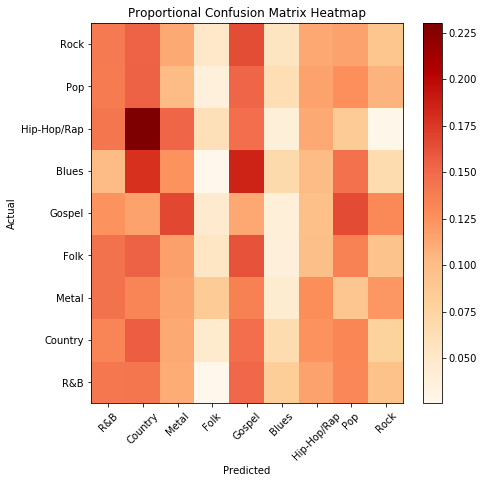

In [14]:
conf_mat_prop=conf_mat.copy()
totals=conf_mat.sum(axis=1)
for col in conf_mat.columns:
    conf_mat_prop[col]=conf_mat_prop[col].div(totals)
plt.figure(figsize=(7,7))
plt.pcolor(conf_mat_prop, cmap='OrRd')
plt.yticks(np.arange(0.5, len(conf_mat_prop.index), 1), conf_mat_prop.index)
plt.xticks(np.arange(0.5, len(conf_mat_prop.columns), 1), conf_mat_prop.columns, rotation=45)
plt.title('Proportional Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.savefig('../Figures/conf_heatmap2.pdf')
plt.show()

### Improved Topics
Performance can possibly be improved by refining the genre vectors. Multiple sources can be combined to produce better vectors. The advantage to this method is that the definition of genres does not depend on the dataset and can be created from external sources with no knoledge of the testing set. 